In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
file_path = 'insurance.csv'
df = pd.read_csv(file_path)

print("=== ORIGINAL DATASET ===")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Smoker distribution:")
print(df['smoker'].value_counts())
print(f"Charges range: ${df['charges'].min():.2f} to ${df['charges'].max():.2f}")


=== ORIGINAL DATASET ===
Dataset shape: (1338, 7)
Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
Smoker distribution:
smoker
no     1064
yes     274
Name: count, dtype: int64
Charges range: $1121.87 to $63770.43


In [ ]:
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
print("No Environmental Impact Score column in insurance dataset.")


No Environmental Impact Score column in insurance dataset.


In [ ]:
df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
unique_regions = df['region'].nunique()
print(f"Number of unique regions: {unique_regions}")
print(f"Regions: {df['region'].unique()}")


Number of unique regions: 4
Regions: ['southwest' 'southeast' 'northwest' 'northeast']


In [ ]:
missing_data = df.isnull().sum()
print(f"Missing Data:\n{missing_data[missing_data > 0]}")
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())


Missing Data:
Series([], dtype: int64)
Dataset shape: (1338, 7)
Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)

numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)

df['sex'] = df['sex'].map({'female': 0, 'male': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})
df['region'] = df['region'].astype('category').cat.codes


In [ ]:
missing_data_after = df.isnull().sum()
print(f"Missing Data After Imputation:\n{missing_data_after[missing_data_after > 0]}")


Missing Data After Imputation:
Series([], dtype: int64)


In [ ]:
print("=== SMART OUTLIER REMOVAL - PRESERVE LEGITIMATE HIGH COSTS ===")
print(f"Before outlier removal: {df.shape[0]} records")

demographic_columns = ['age', 'bmi']
for col in demographic_columns:
    print(f"\nProcessing {col}:")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_condition = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    outliers_count = outlier_condition.sum()
    
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Outliers found: {outliers_count}")
    
    df = df[~outlier_condition]
    print(f"  After removing {col} outliers: {df.shape[0]} records")

print(f"\n=== SMART CHARGES OUTLIER REMOVAL ===")
print(f"Analyzing outliers by smoker status:")

smokers = df[df['smoker'] == 1]
non_smokers = df[df['smoker'] == 0]

print(f"  Smokers: {len(smokers)} records, charges: ${smokers['charges'].mean():.0f} ± ${smokers['charges'].std():.0f}")
print(f"  Non-smokers: {len(non_smokers)} records, charges: ${non_smokers['charges'].mean():.0f} ± ${non_smokers['charges'].std():.0f}")

non_smoker_threshold = non_smokers['charges'].quantile(0.97)
smoker_threshold = smokers['charges'].quantile(0.98)

print(f"\nOutlier thresholds:")
print(f"  Non-smoker threshold (97th percentile): ${non_smoker_threshold:.0f}")
print(f"  Smoker threshold (98th percentile): ${smoker_threshold:.0f}")

non_smokers_filtered = non_smokers[non_smokers['charges'] <= non_smoker_threshold]
smokers_filtered = smokers[smokers['charges'] <= smoker_threshold]

df = pd.concat([non_smokers_filtered, smokers_filtered]).reset_index(drop=True)

outliers_removed = len(smokers) + len(non_smokers) - len(df)
print(f"\nSmart filtering results:")
print(f"  Outliers removed: {outliers_removed} ({outliers_removed/(len(smokers) + len(non_smokers))*100:.1f}%)")
print(f"  Smokers preserved: {len(smokers_filtered)}/{len(smokers)} ({len(smokers_filtered)/len(smokers)*100:.1f}%)")
print(f"  Non-smokers preserved: {len(non_smokers_filtered)}/{len(non_smokers)} ({len(non_smokers_filtered)/len(non_smokers)*100:.1f}%)")

print(f"\nFinal dataset after smart outlier removal: {df.shape[0]} records")
print(f"Smoker distribution after outlier removal:")
print(df['smoker'].value_counts())


=== SMART OUTLIER REMOVAL - PRESERVE LEGITIMATE HIGH COSTS ===
Before outlier removal: 1291 records

Processing age:
  Q1: 26.00, Q3: 51.00, IQR: 25.00
  Outliers found: 0
  After removing age outliers: 1291 records

Processing bmi:
  Q1: 26.21, Q3: 34.41, IQR: 8.20
  Outliers found: 1
  After removing bmi outliers: 1290 records

=== SMART CHARGES OUTLIER REMOVAL ===
Analyzing outliers by smoker status:
  Smokers: 265 records, charges: $31273 ± $10855
  Non-smokers: 1025 records, charges: $7800 ± $4840

Outlier thresholds:
  Non-smoker threshold (97th percentile): $19546
  Smoker threshold (98th percentile): $48639

Smart filtering results:
  Outliers removed: 37 (2.9%)
  Smokers preserved: 259/265 (97.7%)
  Non-smokers preserved: 994/1025 (97.0%)

Final dataset after smart outlier removal: 1253 records
Smoker distribution after outlier removal:
smoker
0    994
1    259
Name: count, dtype: int64


In [ ]:
df['charges'] = df['charges'].astype(float)


In [ ]:
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65], labels=['Young', 'Adult', 'Middle-aged', 'Senior'])

df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 50], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

df['age_bmi_interaction'] = df['age'] * df['bmi']
df['smoker_age_interaction'] = df['smoker'] * df['age']


In [ ]:
df = pd.get_dummies(df, columns=['age_group', 'bmi_category'], drop_first=True)


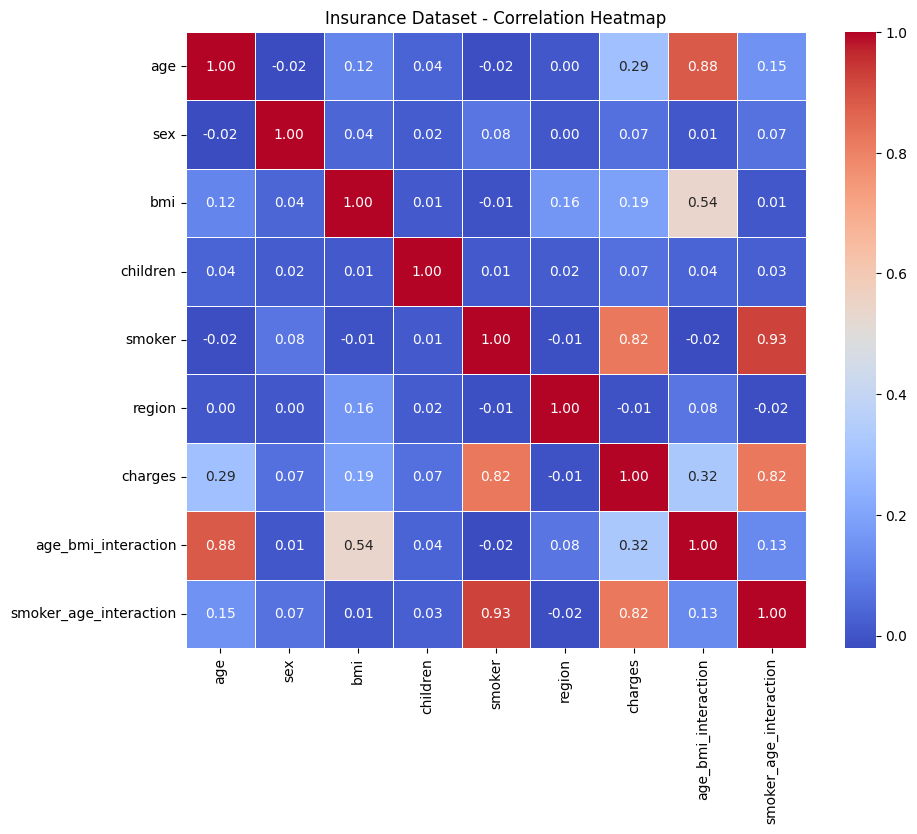

Correlation with charges:
charges                   1.000000
smoker_age_interaction    0.824407
smoker                    0.823326
age_bmi_interaction       0.324271
age                       0.290860
bmi                       0.189642
sex                       0.066206
children                  0.065795
region                   -0.006859
Name: charges, dtype: float64


In [ ]:
plt.figure(figsize=(10, 8))
numerical_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Insurance Dataset - Correlation Heatmap')
plt.show()

print("Correlation with charges:")
charges_corr = correlation_matrix['charges'].sort_values(key=abs, ascending=False)
print(charges_corr)


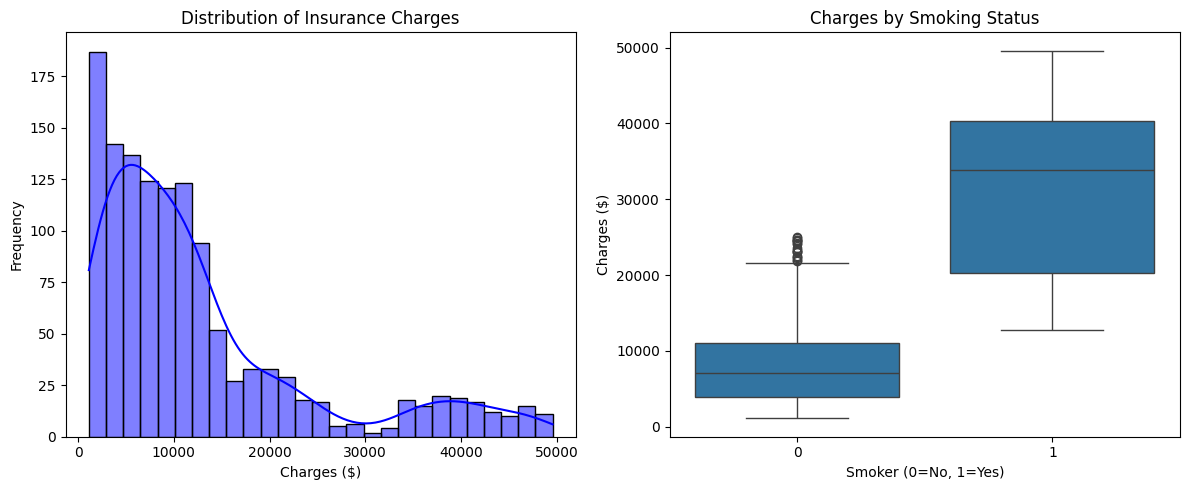

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['smoker'], y=df['charges'])
plt.title('Charges by Smoking Status')
plt.xlabel('Smoker (0=No, 1=Yes)')
plt.ylabel('Charges ($)')

plt.tight_layout()
plt.show()


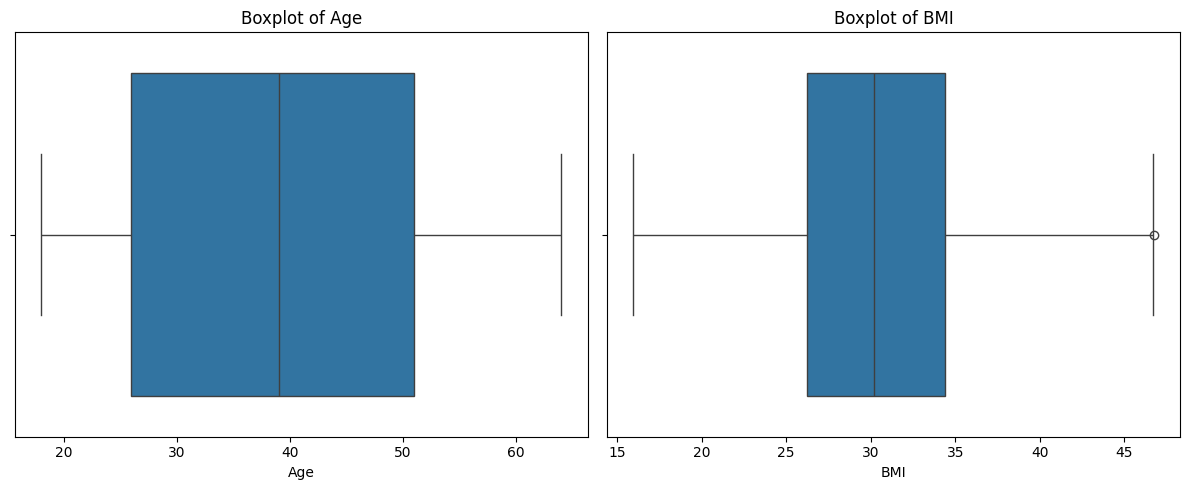

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['age'])
plt.title('Boxplot of Age')
plt.xlabel('Age')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['bmi'])
plt.title('Boxplot of BMI')
plt.xlabel('BMI')

plt.tight_layout()
plt.show()


In [ ]:
print("No date columns in insurance dataset. Skipping date processing.")


No date columns in insurance dataset. Skipping date processing.


In [ ]:
missing_data_after_cleaning = df.isnull().sum()
print(f"Missing Data After Cleaning:\n{missing_data_after_cleaning[missing_data_after_cleaning > 0]}")


Missing Data After Cleaning:
Series([], dtype: int64)


In [ ]:
df.to_csv('cleaned_insurance_data.csv', index=False)
print("Cleaned insurance data saved to 'cleaned_insurance_data.csv'")
print(f"Final dataset shape: {df.shape}")
print(f"Final columns: {df.columns.tolist()}")


Cleaned insurance data saved to 'cleaned_insurance_data.csv'
Final dataset shape: (1253, 15)
Final columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'age_bmi_interaction', 'smoker_age_interaction', 'age_group_Adult', 'age_group_Middle-aged', 'age_group_Senior', 'bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese']
